In [1]:
import pykat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

%matplotlib inline

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
description = '''
Using FINESSE to calculate the PRC and the ARM build up as functions of the round trip loss and mode mismatch.

The modes are placed in mostly the second order.  To account for the point absorber, the higher order mode contributions
are placed as a loss.
'''

In [43]:
kat_code = '''
%%% FTblock laser
###########################################################################
# Laser and input optics
l L0 30 0.0 0.0 ni
bs jitter 1 0 0 0 ni n0 dump dump
s lmod1 1 n0 n1
# modulators for core interferometer sensing - Advanced LIGO, CQG, 2015 
# http://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001/meta#cqg507871s4-8
# 9MHz (CARM, PRC, SRC loops)
const f1 9099471
const f2 45497355
mod mod1 $f1 0.18 1 pm n1 n2
s lmod2 1 n2 n3
# 45MHz (MICH, SRC loops)
mod mod2 $f2 0.18 1 pm n3 nLaserOut
###########################################################################
%%% FTend laser

%%% FTblock PRC
###########################################################################
s sLaser_PRC 0 nLaserOut nFI1

# Isolator component
dbs FI nFI1 nFI2 nFI3 nREFL
s sFI_PRM 0 nFI3 nPRM1

# PRM
# AR surface
m2 PRMAR 0 40u 0 nPRM1 nPRMs1
# Substrate
s sPRMsub1 0.0737 $nsilica nPRMs1 nPRMs2
# HR surface
m1 PRM 0.03 8.5u $phi_PRM nPRMs2 nPRM2
attr PRM Rc 11.009
# Distance between PRM and PR2
s lp1 16.6107 nPRM2 nPR2a
# PR2
bs1 PR2 250u $Mloss 0 -0.79 nPR2a nPR2b nPOP nAPOP
attr PR2 Rc -4.545
# Distance from PR2 to PR3
s lp2 16.1647 nPR2b nPR3a
# PR3
bs1 PR3 0 $Mloss 0 0.615 nPR3a nPR3b dump12 dump13
attr PR3 Rc 36.027
# Distance from PR3
s lp3 19.5381 nPR3b nPRBS

###########################################################################
%%% FTend PRC

%%% FTblock BS
###########################################################################
# BS beamsplitter
##------------------------------------------------------------ 
## BS 
##                             ^ 
##                  to IMY     |      
##                             |      ,'-.
##                             |     +    `. 
##                        nYBS |   ,'       :'
##      nPR3b                  |  +i1      +
##         ---------------->    ,:._  i2 ,'
##    from the PRC       nPRBS + \  `-. + nXBS
##                           ,' i3\   ,' --------------->
##                          +      \ +     to IMX
##                        ,'     i4.'
##                       `._      ..
##                          `._ ,' |nSRBS
##                             -   |
##                                 |to the SRC
##                                 |
##                                 v
##------------------------------------------------------------
bs1 BS 1.0 0.0 $phi_BS 45 nPRBS nYBS nBSi1 nBSi3
s BSsub1 0.0687 $nsilica nBSi1 nBSi2
s BSsub2 0.0687 $nsilica nBSi3 nBSi4
bs2 BSAR1 50u 0 0 -29.195 nBSi2 dump14 nXBS nPOX
bs2 BSAR2 50u 0 0 29.195 nBSi4 dump15 nSRBS dump16

###########################################################################
%%% FTend BS


%%% FTblock Xarm
###########################################################################

# Distance from beam splitter to X arm input mirror 
s lx1 4.993 nXBS nITMX1a

# Thermal lens correction
lens ITMX_therm $th_f nITMX1a nITMX_th1
s ITMX_th1 0 nITMX_th1 nITMX_th2
lens ITMX_lens inf nITMX_th2 nITMX_th3
s ITMX_th2 0 nITMX_th3 nITMX1

# X arm input mirror
m2 ITMXAR 0 20u 0 nITMX1 nITMXs1 
s ITMXsub 0.2 $nsilica nITMXs1 nITMXs2
m1 ITMX 0.015 $Mloss $phi_ITMX nITMXs2 nITMX2
attr ITMX Rc -1934

# X arm length
s LX $Larm nITMX2 nETMX1

# X arm end mirror
m1 ETMX 5u $Mloss $phi_ETMX nETMX1 nETMXs1
s ETMXsub 0.2 $nsilica nETMXs1 nETMXs2
m2 ETMXAR 0 500u 0 nETMXs2 nPTX 
attr ETMX Rc 2245
attr ETMX mass 40
attr ITMX mass 40

###########################################################################
%%% FTend Xarm


%%% FTblock cavities
###########################################################################
cav cavXARM ITMX nITMX2 ETMX nETMX1
cav cavPRX PRM nPRM2 ITMX nITMXs2
###########################################################################
%%% FTend cavities

%%% FTblock constants
###########################################################################
const nsilica 1.44963098985906
const nTGG 1.954
const nCalcite 1.65846
const Mloss 37.5u
#const Mloss 0.0
const Larm 3994.4692
const fM 36.397884M
const fP 54.596826M
const th_f 34.5k
###########################################################################
%%% FTend constants

%%% FTblock tunings
###########################################################################
const phi_PRM 0.01
const phi_ITMX 0.0
const phi_ETMX 0.0
const phi_BS 0
###########################################################################
%%% FTend tunings

%%% FTblock powers
###########################################################################
pd P_DC_AS nSRBS
pd PIMCtrans nREFL*
pd Prefl nREFL
pd Px nITMX2
pd Pprc nPRM2
ad prc0 0 nPRM2
ad prcf1 $f1 nPRM2
ad prcf2 $f2 nPRM2
###########################################################################
%%% FTend powers

%%% FTblock errsigs
###########################################################################

# N.B. the I signal refers to most symmetric signal, not greatest slope.
pd1 REFL_f1_I $f1 101 nREFL
pd1 REFL_f1_Q $f1 191 nREFL
pd1 REFL_f2_I $f2 14 nREFL
pd1 REFL_f2_Q $f2 104 nREFL
pd1 POP_f1_I $f1 101 nPOP
pd1 POP_f1_Q $f1 191 nPOP
pd1 POP_f2_I $f2 13 nPOP
pd1 POP_f2_Q $f2 103 nPOP
#pd1 OMClockpd $fdither -1.22 nAS

pd1 POP_18_I 18198942 max nPRM2
pd1 POP_90_I 90994710 max nPRM2

###########################################################################
%%% FTend errsigs

noxaxis
maxtem 2
bp q_in x q nLaserOut
yaxis re:im

'''

def try_it(kat_in):
    result =None
    while result is None:    
        try:
            out = kat_in.run()
            result = 1
        except:
            print("Ran into a pipe error, running again")
            continue

    return out

In [44]:
avg_arm_T = (0.015 + 0.0142)/2

In [177]:
basekat = pykat.finesse.kat() 
basekat.parse(kat_code)

size = 25

Loss = np.linspace(0,80e-6,size)
dRc = np.linspace(0,15e-6,size)

Pprc  = np.ones((Loss.size,dRc.size))
Parm    = np.ones((Loss.size,dRc.size))
POP18 = np.ones((Loss.size,dRc.size))
Pas = np.ones((Loss.size,dRc.size))
Prefl = np.ones((Loss.size,dRc.size))

In [178]:
for i in range(len(Loss)):
    kat=basekat.deepcopy()
    kat.verbose = False
    orig = kat.ETMX.Rc.value
    
    #Put all the losses in the ETM
    kat.ITMX.L=0

    kat.ETMX.L= Loss[i]
    
    for j in range(len(dRc)):
        kat.ETMX.Rc = (1./orig + dRc[j])**(-1)
        result =None
        while result is None:    
            try:
                out = kat.run()
                result = 1
            except:
                print("Ran into a pipe error, running again")
                continue
        
        Pprc[j][i]  = np.real(out['Pprc'])/kat.L0.P.value
        Parm[j][i]    = np.real(out['Px'])/2
        POP18[j][i] = np.real(out['POP_18_I'])
        Pas[j][i] = np.real(out['P_DC_AS'])


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
E

In [179]:
#find mismatch parameters
kat=basekat.deepcopy()
kat.verbose = False
orig = kat.ETMX.Rc.value
mismatch = []

for i in range(len(dRc)):
    
    kat.ETMX.Rc = (1./orig - dRc[i])**(-1)

    kat.cavPRX.enabled = False
    kat.cavXARM.enabled = True
    
    out = try_it(kat)
    q_arm = out['q_in']
    
    kat.cavPRX.enabled = True
    kat.cavXARM.enabled = False
    
    out = try_it(kat)
    q_prx = out['q_in']
    
    print(q_arm,q_prx)

    mismatch.append(1-pykat.BeamParam.overlap(q_arm,q_prx))

mismatch = np.array(mismatch)

(-5.89074277699115+3.07939698084483j) (-5.88682825711863+3.13636787214511j)
(-5.88876299441305+3.10834133980428j) (-5.88682825711863+3.13636787214511j)
(-5.88677053224113+3.13720020765624j) (-5.88682825711863+3.13636787214511j)
(-5.88476526827353+3.16597764399974j) (-5.88682825711863+3.13636787214511j)
(-5.88274707873275+3.1946775775624j) (-5.88682825711863+3.13636787214511j)
(-5.88071583824137+3.22330381335956j) (-5.88682825711863+3.13636787214511j)
(-5.87867141979426+3.25186003938938j) (-5.88682825711863+3.13636787214511j)
(-5.87661369473346+3.28034983290243j) (-5.88682825711863+3.13636787214511j)
(-5.87454253272086+3.30877666627737j) (-5.88682825711863+3.13636787214511j)
(-5.8724578017099+3.3371439125334j) (-5.88682825711863+3.13636787214511j)
(-5.87035936791835+3.36545485050782j) (-5.88682825711863+3.13636787214511j)
(-5.86824709580063+3.3937126697232j) (-5.88682825711863+3.13636787214511j)
(-5.86612084801626+3.42192047496694j) (-5.88682825711863+3.13636787214511j)
(-5.863980485401

In [180]:
mismatch

array([8.44038510e-05, 2.02385294e-05, 1.76868910e-08, 2.21803676e-05,
       8.52418719e-05, 1.87789168e-04, 3.28476637e-04, 5.06022122e-04,
       7.19203255e-04, 9.66854046e-04, 1.24786170e-03, 1.56116365e-03,
       1.90574482e-03, 2.28063498e-03, 2.68490643e-03, 3.11767165e-03,
       3.57808126e-03, 4.06532201e-03, 4.57861492e-03, 5.11721358e-03,
       5.68040248e-03, 6.26749550e-03, 6.87783445e-03, 7.51078774e-03,
       8.16574908e-03])

In [181]:
def plot_results(Pprc,Parm):
    X,Y = np.meshgrid(Loss*1e6,mismatch*1e2)

    fig = plt.figure(figsize=(10,10),dpi=100)
    cmap = plt.cm.get_cmap("rainbow")

    xlabel = 'Round Trip Loss [PPM]'
    ylabel = 'Mode Mismatch between PRC and ARM [%]'

    ax = fig.add_subplot(221)
    levels = np.linspace(0.0,100,11)
    FS = ax.contourf(X, Y, Pprc,alpha=.25,cmap=cmap,levels=levels)
    CS = ax.contour(X, Y, Pprc, cmap=cmap, levels= levels)
    ax.clabel(CS, fontsize=10, colors='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title('Power Recycling Gain')

    ax = fig.add_subplot(222)
    levels = np.linspace(0.0,500,11)
    FS = ax.contourf(X, Y, Parm/1e3,alpha=.25,cmap=cmap,levels=levels)
    CS = ax.contour(X, Y, Parm/1e3, cmap=cmap, levels= levels)
    ax.clabel(CS, fontsize=10, colors='black')
    ax.set_xlabel(xlabel)
    ax.set_title('Arm Build Up [kW]')

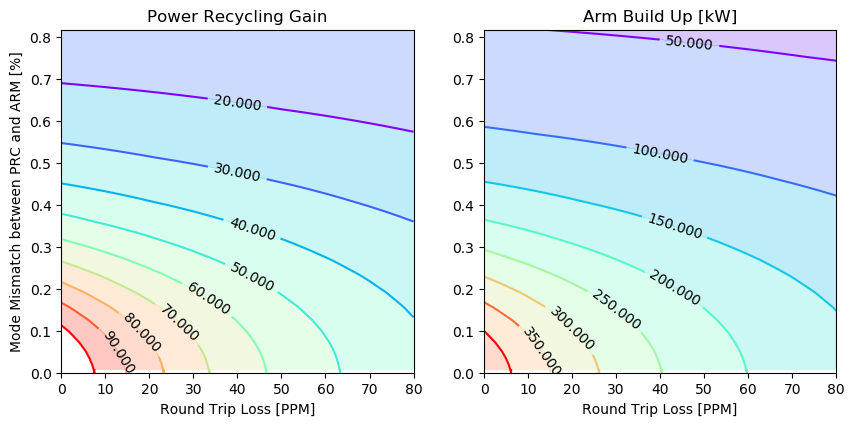

In [182]:
plot_results(Pprc,Parm)

In [187]:
absorption = np.linspace(0,450e-9,size)
Loss = np.linspace(0,175e-6,size)

alpha_sur = -3.60e-5 #diopters per watt
alpha_sub = (4.87e-4)/2 #diopters per watt

mismatch = np.ones((Loss.size,dRc.size))

for i in range(len(Loss)):
    kat=basekat.deepcopy()
    kat.verbose = False
    
    orig_f = kat.ITMX_therm.f.value
    orig_R = kat.ITMX.Rc.value
    
    #Put all the losses in the ITM
    kat.ITMX.L=0
    kat.ETMX.L= Loss[i]
    
    out = try_it(kat)
    
    #arm power with some losses, no mode mismatch yet
    p_arm = np.real(out['Px'])
    

    # Now the mode mismatch is proportional to the change in focal length of the ITM substrate as well
    # as the radius of curvature of the input test mass, I expect the latter to be small.
    for j in range(len(absorption)):
        dRoc = p_arm * alpha_sur * absorption[j]
        dFoc = p_arm * alpha_sub * absorption[j]
        
        kat.ITMX_therm.f = (1./orig_f + dFoc )**(-1)
        kat.ITMX.Rc      = (1./orig_R + dRoc )**(-1)

        # Run with new parameters
        out = try_it(kat)
        #out = kat.run()
        
        Pprc[j][i]  = np.real(out['Pprc'])/kat.L0.P.value
        Parm[j][i]    = np.real(out['Px'])/2
        #POP18[j][i] = np.real(out['POP_18_I'])
        POP18[j][i] = np.absolute(out['prcf1'])
        Pas[j][i] = np.real(out['P_DC_AS'])
        Prefl[j][i] = np.real(out['Prefl'])
    
        #calculate the amount of mode mismatch per absorption, let Finesse do the hard work!
        
        kat.cavPRX.enabled = False
        kat.cavXARM.enabled = True

        out = try_it(kat)
        #out = kat.run()
        q_arm = out['q_in']

        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = False

        out = try_it(kat)
        q_prx = out['q_in']

        mismatch[j][i]= 1-pykat.BeamParam.overlap(q_arm,q_prx)
        
        ## Turn the cavities back on!
        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = True

X,Y = np.meshgrid(Loss*1e6,absorption*1e9)


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
E


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
E

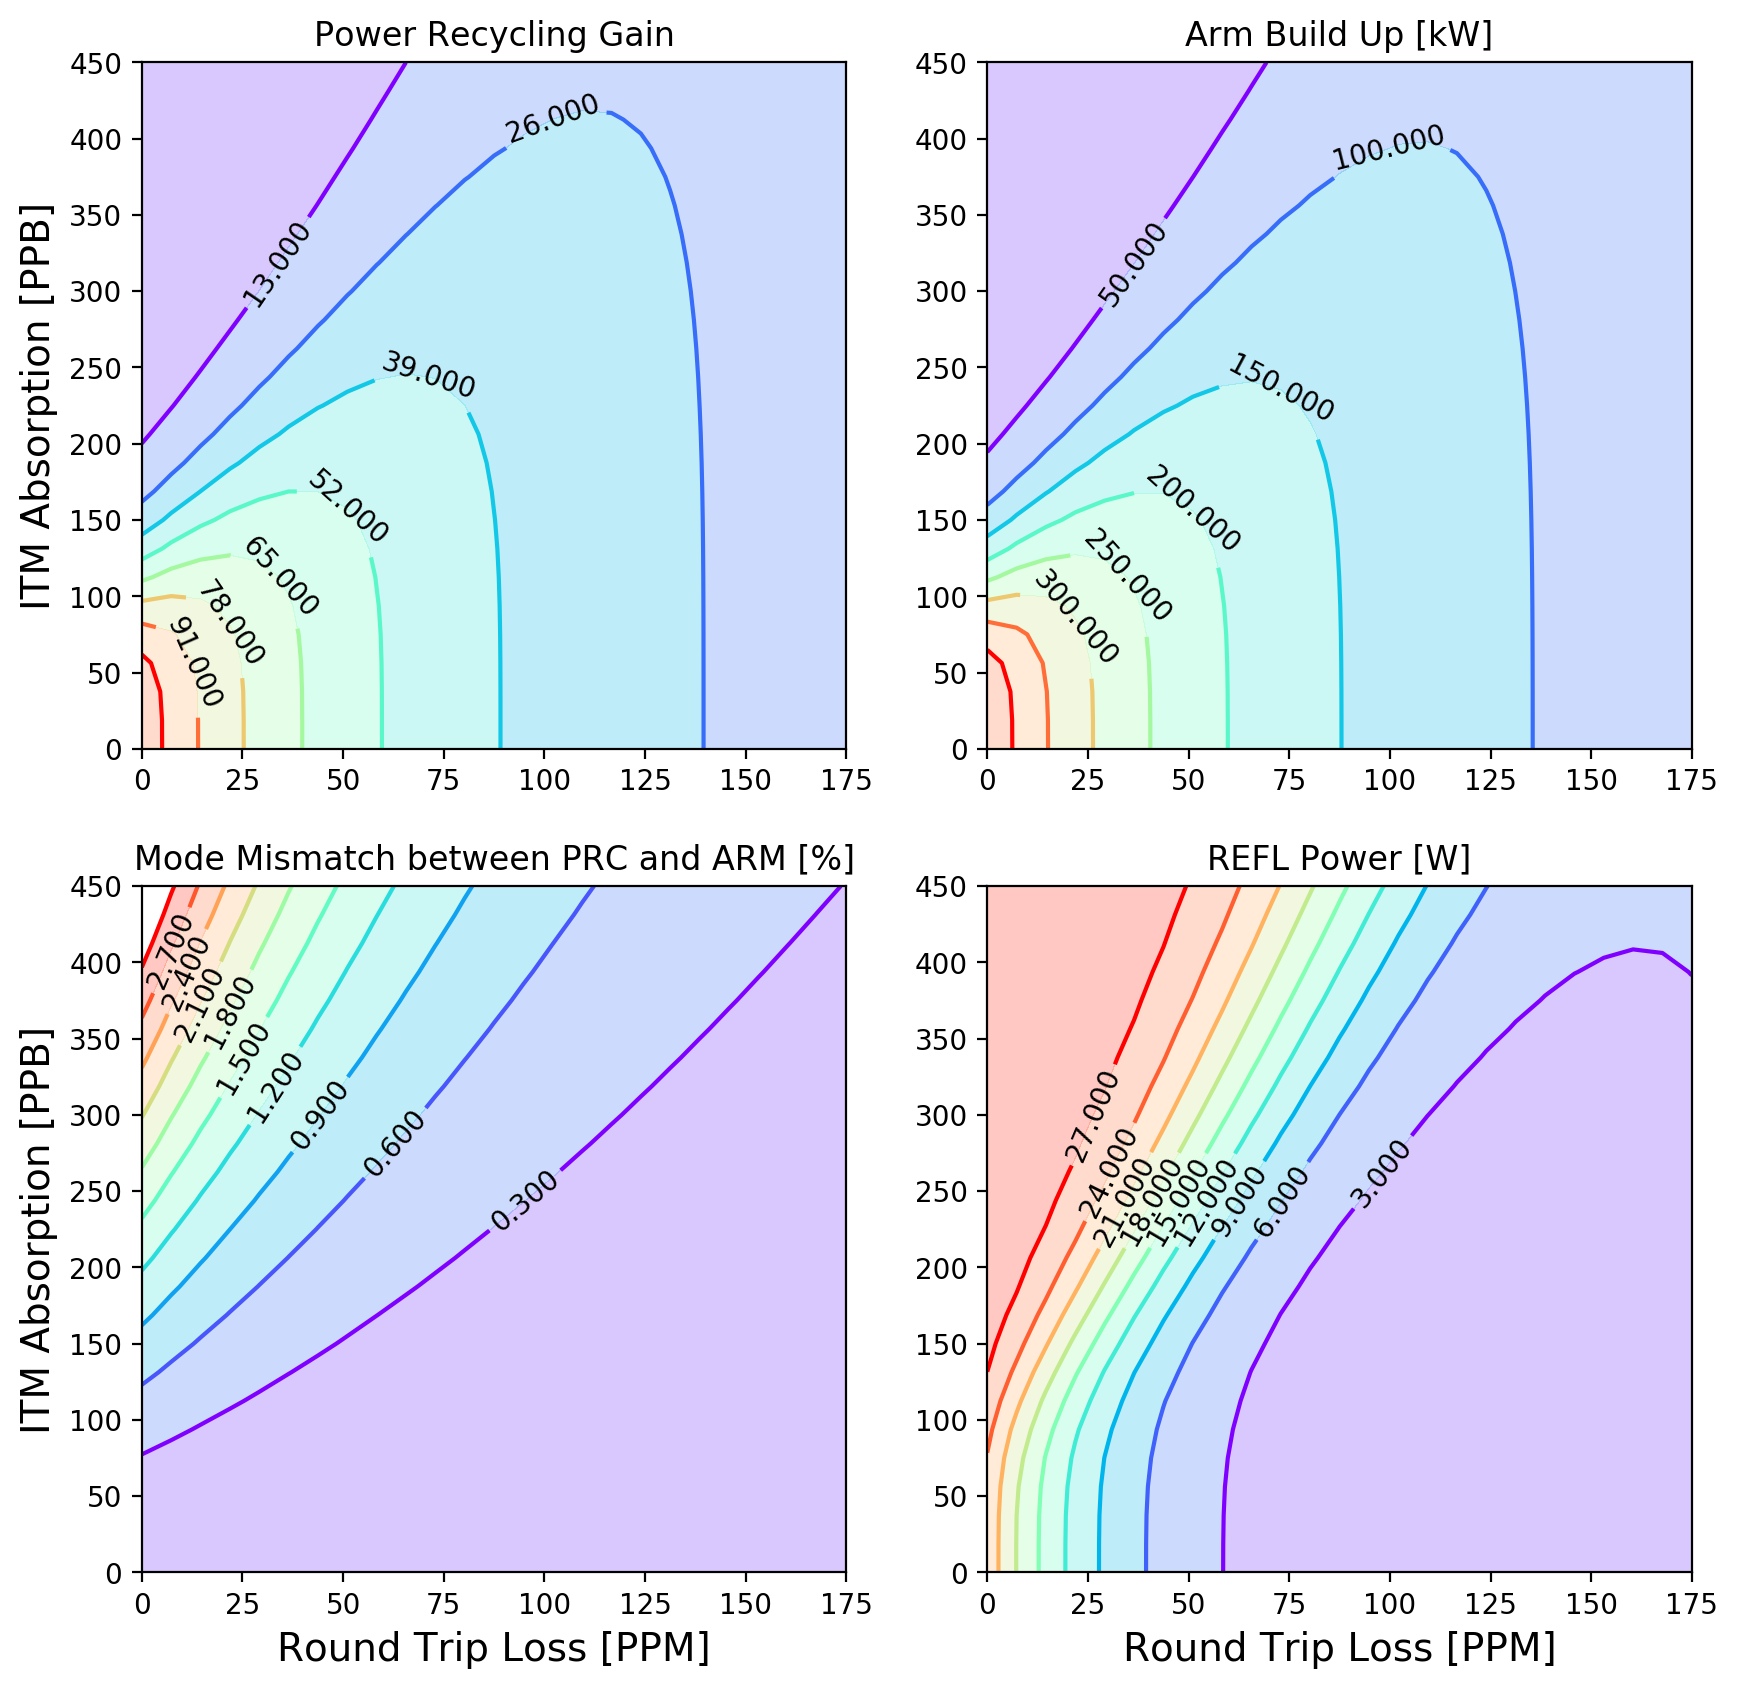

In [188]:
### PLot
fig = plt.figure(figsize=(10,10),dpi=200)
cmap = plt.cm.get_cmap("rainbow")

xlabel = 'Round Trip Loss [PPM]'
ylabel = 'ITM Absorption [PPB]'

ax = fig.add_subplot(221)
levels = np.linspace(0.0,130,11)

FS = ax.contourf(X, Y, Pprc,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Pprc, cmap=cmap, levels=levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel,fontsize=14)
ax.set_title('Power Recycling Gain')

ax = fig.add_subplot(222)
levels = np.linspace(0.0,500,11)
FS = ax.contourf(X, Y, Parm/1e3,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Parm/1e3, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_title('Arm Build Up [kW]')

ax = fig.add_subplot(223)
levels = np.linspace(0.0,3.0,11)
#FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap,levels=levels)
#CS = ax.contour(X, Y, mismatch*100, cmap=cmap,levels=levels)

FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, mismatch*100, cmap=cmap,levels=levels)
ax.clabel(CS, fontsize=10, colors='black')
ax.set_xlabel(xlabel,fontsize=14)
ax.set_ylabel(ylabel,fontsize=14)
ax.set_title('Mode Mismatch between PRC and ARM [%]')

import matplotlib.ticker as ticker
ax = fig.add_subplot(224)
levels = np.linspace(0.0,30,11)
FS = ax.contourf(X, Y,Prefl,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y,Prefl, cmap=cmap,levels=levels)

#fmt = ticker.LogFormatterMathtext()
#fmt.create_dummy_axis()
ax.clabel(CS, fontsize=10, colors='black')

ax.set_xlabel(xlabel,fontsize=14)
ax.set_title('REFL Power [W]')

plt.savefig('../../../Figures/Simplified_PRC_ARM_itm_abs.png')

In [189]:
absorption = np.linspace(0,1400e-9,size)
Loss = np.linspace(0,175e-6,size)

mismatch = np.ones((Loss.size,dRc.size))

for i in range(len(Loss)):
    kat=basekat.deepcopy()
    kat.verbose = False
    
    orig_R = kat.ETMX.Rc.value
    
    #Put all the losses in the ITM
    kat.ITMX.L=0
    kat.ETMX.L= Loss[i]
    
    out = try_it(kat)
    
    #arm power with some losses, no mode mismatch yet
    p_arm = np.real(out['Px'])
    

    # Now the mode mismatch is proportional to the change in focal length of the ITM substrate as well
    # as the radius of curvature of the input test mass, I expect the latter to be small.
    for j in range(len(absorption)):
        dRoc = p_arm * alpha_sur * absorption[j]
        dFoc = p_arm * alpha_sub * absorption[j]
        
        #kat.ITMX_therm.f = (1./orig_f + dFoc )**(-1)
        kat.ETMX.Rc      = (1./orig_R + dRoc )**(-1)

        # Run with new parameters
        out = try_it(kat)
        #out = kat.run()
        
        Pprc[j][i]  = np.real(out['Pprc'])/kat.L0.P.value
        Parm[j][i]    = np.real(out['Px'])/2
        POP18[j][i] = np.real(out['POP_18_I'])
        Pas[j][i] = np.real(out['P_DC_AS'])
        Prefl[j][i] = np.real(out['Prefl'])
    
        #calculate the amount of mode mismatch per absorption, let Finesse do the hard work!
        
        kat.cavPRX.enabled = False
        kat.cavXARM.enabled = True

        out = try_it(kat)
        #out = kat.run()
        q_arm = out['q_in']

        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = False

        out = try_it(kat)
        q_prx = out['q_in']

        mismatch[j][i]= 1-pykat.BeamParam.overlap(q_arm,q_prx)
        
        ## Turn the cavities back on!
        kat.cavPRX.enabled = True
        kat.cavXARM.enabled = True

X,Y = np.meshgrid(Loss*1e6,absorption*1e9)


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
E


--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
Error:   Failed to make connection on named pipe.
Error=535
--------------------------------------------------------------

Ran into a pipe error, running again

--------------------------------------------------------------
Error from Finesse (See 'pykat.lastErrorKat' for kat object):
  
E

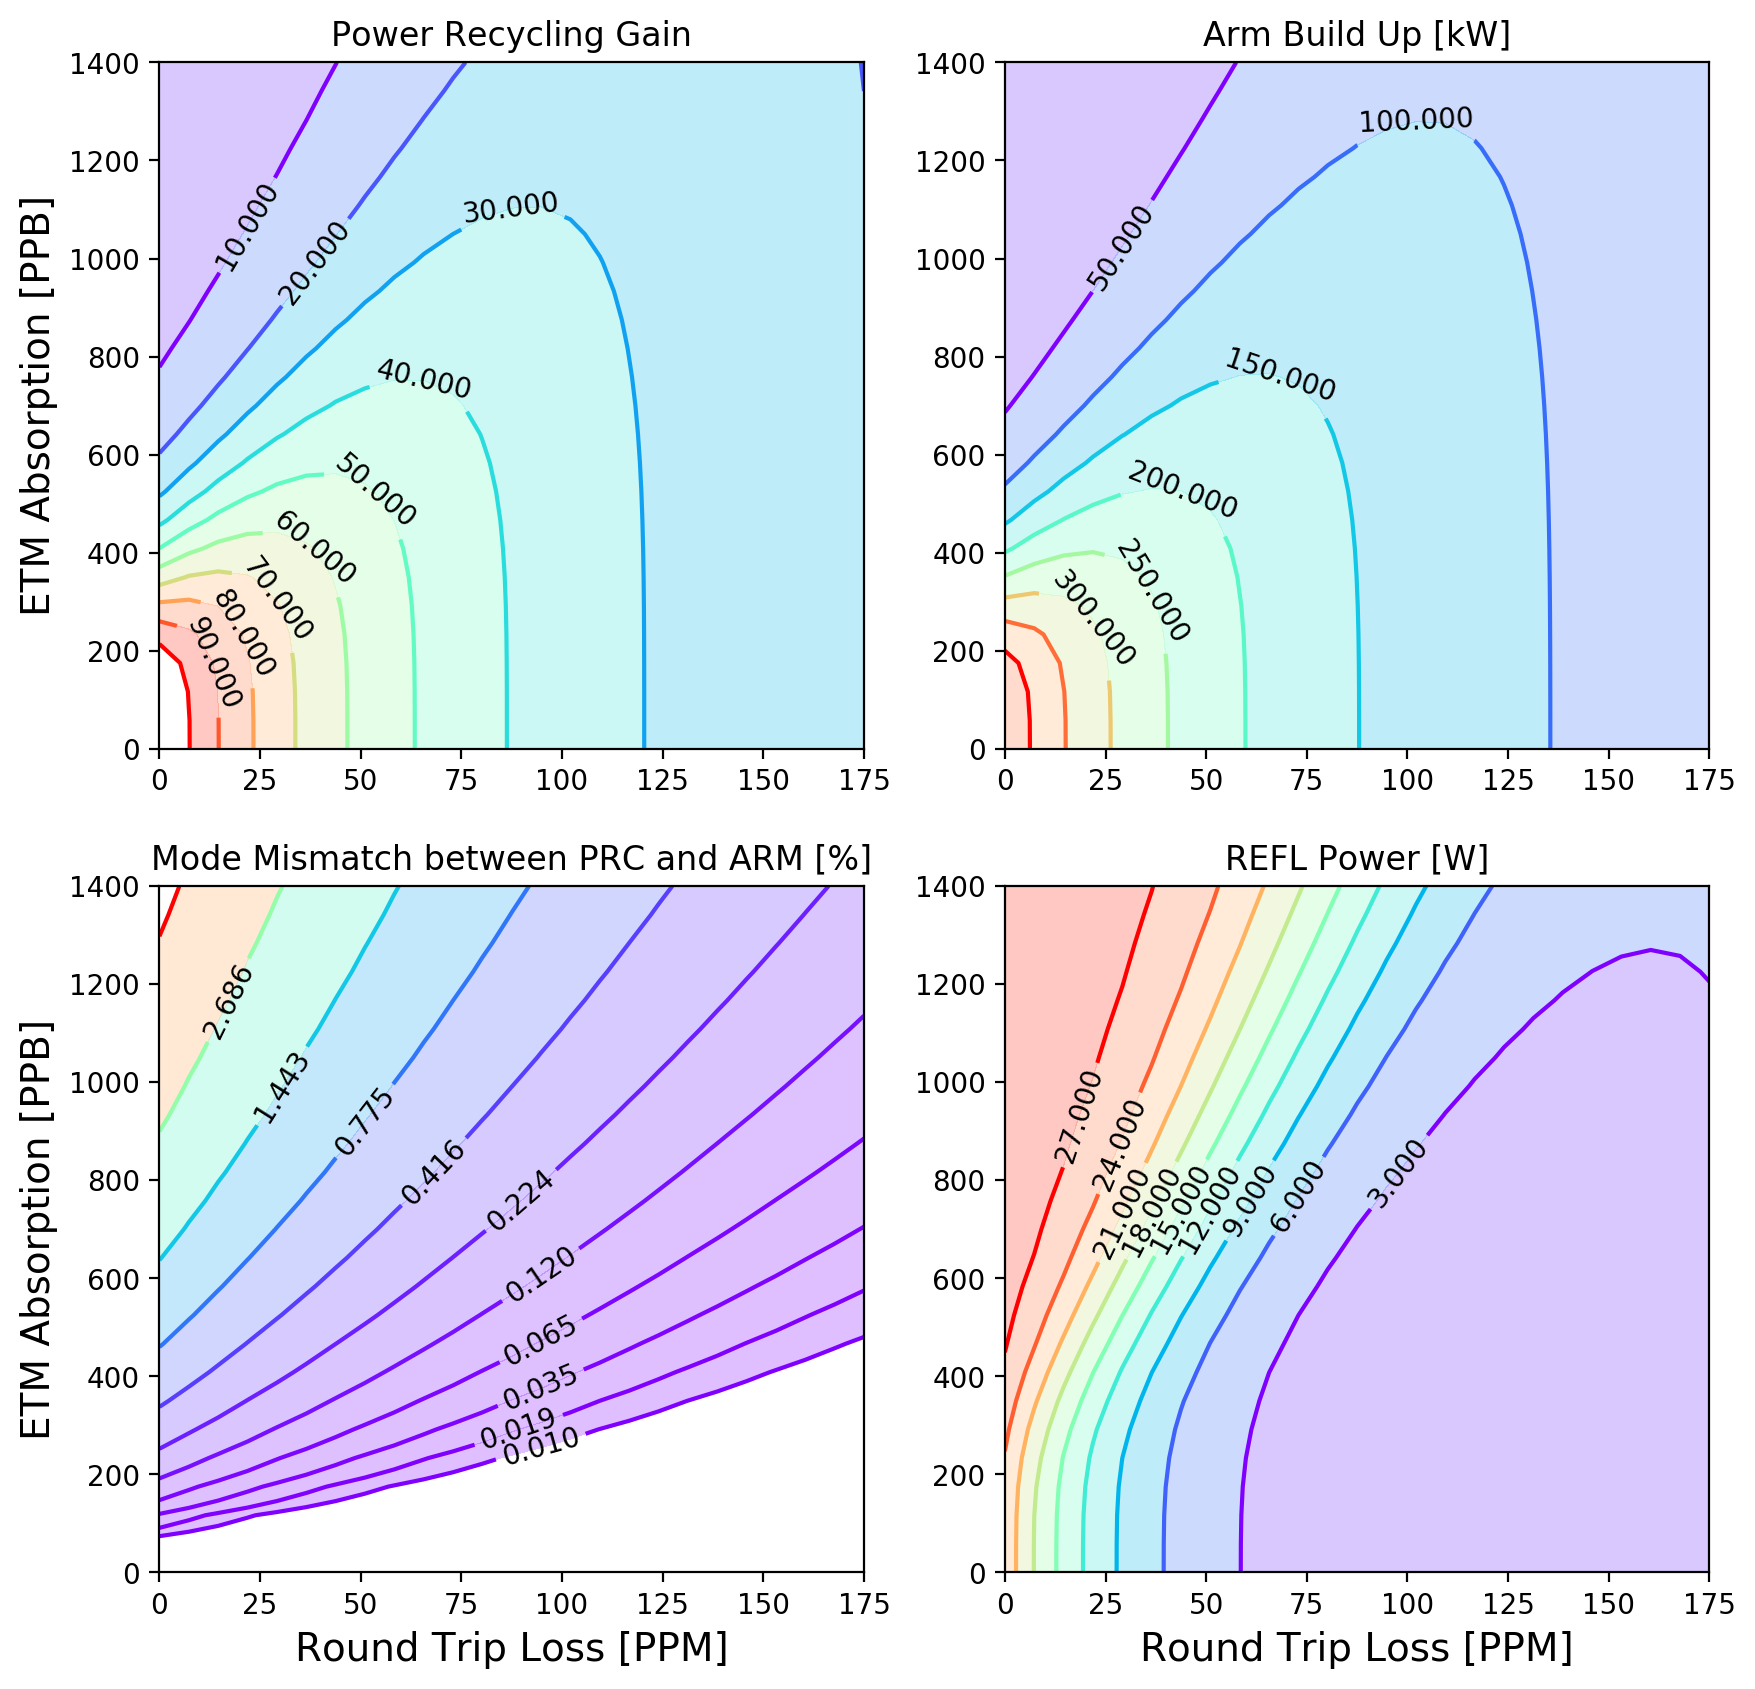

In [190]:
### PLot
fig = plt.figure(figsize=(10,10),dpi=200)
cmap = plt.cm.get_cmap("rainbow")

xlabel = 'Round Trip Loss [PPM]'
ylabel = 'ETM Absorption [PPB]'

ax = fig.add_subplot(221)
levels = np.linspace(0.0,100,11)
FS = ax.contourf(X, Y, Pprc,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Pprc, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel,fontsize=14)
ax.set_title('Power Recycling Gain')

ax = fig.add_subplot(222)
levels = np.linspace(0.0,500,11)
FS = ax.contourf(X, Y, Parm/1e3,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, Parm/1e3, cmap=cmap, levels= levels)
ax.clabel(CS, fontsize=10, colors='black')
#ax.set_xlabel(xlabel)
ax.set_title('Arm Build Up [kW]')


ax = fig.add_subplot(223)
levels = np.linspace(0.0,3.5,6)
levels = np.geomspace(0.01,5,11)
#FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap,levels=levels)
#CS = ax.contour(X, Y, mismatch*100, cmap=cmap,levels=levels)

FS = ax.contourf(X, Y, mismatch*100,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y, mismatch*100, cmap=cmap,levels=levels)
ax.clabel(CS, fontsize=10, colors='black')
ax.set_xlabel(xlabel,fontsize=14)
ax.set_ylabel(ylabel,fontsize=14)
ax.set_title('Mode Mismatch between PRC and ARM [%]')

import matplotlib.ticker as ticker
ax = fig.add_subplot(224)
levels = np.linspace(0.0,30,11)
FS = ax.contourf(X, Y,Prefl,alpha=.25,cmap=cmap,levels=levels)
CS = ax.contour(X, Y,Prefl, cmap=cmap,levels=levels)

#fmt = ticker.LogFormatterMathtext()
#fmt.create_dummy_axis()
ax.clabel(CS, fontsize=10, colors='black')

ax.set_xlabel(xlabel,fontsize=14)
ax.set_title('REFL Power [W]')

plt.savefig('../../../Figures/Simplified_PRC_ARM_etm_abs.png')